In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import stan 

import arviz as az 

import nest_asyncio
nest_asyncio.apply()

In [43]:
DISPLAY_X, DISPLAY_Y = 2560, 1080

In [32]:
# Read in the data
dataset = pd.read_csv("../data/full_data.csv", delimiter=";")

In [33]:
dataset.head(5)

,Timestamp,Lap_Number,Position.x.,Position.z.,Orientation.y.,Gaze_Location.x.,Gaze_Location.y.,Gaze_Location.z.,Subject,Gaze.x.,Gaze.y.,d_ang,ang_accel,Gate_N,Gate.x.,Gate.z.,Ang_Pos
0,1688764397682,0,-255.4,-181.8494,-3.000000e-08,-270.743971,351.035293,-138.685157,1,1157.282,434.3420,-1.764706e-07,2.209487e-06,1,-261.2452,-135.0596,0.654205
1,1688764397699,0,-255.4,-181.7235,0.000000e+00,-270.748529,351.077679,-138.680800,1,1157.288,434.6814,-1.764706e-07,3.604383e-09,1,-261.2452,-135.0596,0.659015
2,1688764397715,0,-255.4,-181.5985,0.000000e+00,-270.753086,351.120064,-138.676443,1,1157.295,435.0208,-9.803922e-09,3.604383e-09,1,-261.2452,-135.0596,0.652319
3,1688764397732,0,-255.4,-181.4766,0.000000e+00,-270.460614,351.141679,-138.868614,1,1159.131,435.3366,-9.803922e-09,-1.099337e-06,1,-261.2452,-135.0596,0.634254
4,1688764397748,0,-255.4,-181.3582,0.000000e+00,-270.292557,351.172114,-138.796529,1,1160.693,435.5298,-9.803922e-09,-6.127451e-08,1,-261.2452,-135.0596,0.614264


In [44]:
## Get rid of data with extreme values
dataset = dataset[
    (dataset['Gaze.x.'] != 0) & 
    (dataset['Gaze.x.'] != DISPLAY_X) & 
    (dataset['Gaze.y.'] != 0) & 
    (dataset['Gaze.y.'] != DISPLAY_Y)
]

In [49]:
## Normalizing the data
gaze_x = dataset['Gaze.x.'] / DISPLAY_X - 0.5
gaze_y = dataset['Gaze.y.'] / DISPLAY_Y - 0.5

76.3855868562283

<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

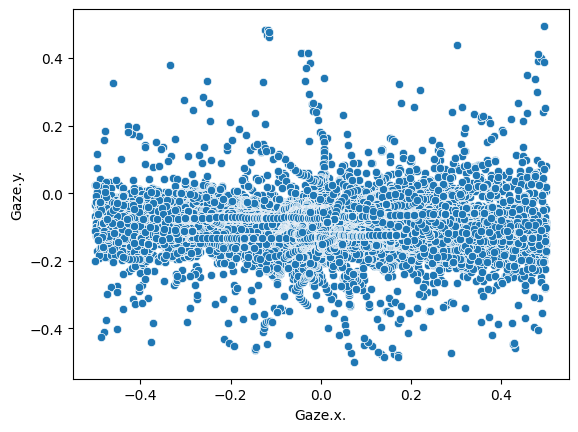

In [46]:
sns.scatterplot(x=gaze_x, y=gaze_y)

<Axes: xlabel='Gaze.x.', ylabel='Count'>

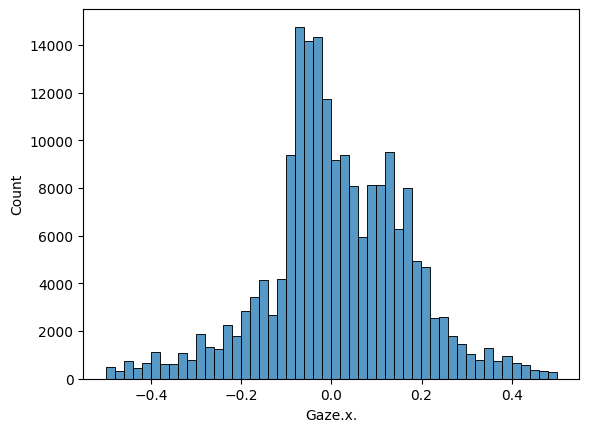

In [47]:
sns.histplot(gaze_x, bins=50)

<Axes: xlabel='Ang_Pos', ylabel='Count'>

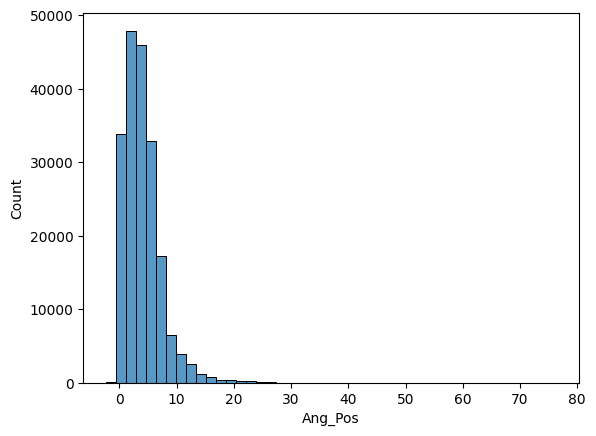

In [54]:
sns.histplot(dataset['Ang_Pos'], bins=45)

In [42]:
dataset['Gaze.x.'].shape == dataset['Gaze.y.'].shape == dataset['Ang_Pos'].shape

True

## Hierarchical Linear Regression

\begin{equation}
    p_{n,j} \sim \mathcal{N}(\beta_{0, j[n]} + \beta_{1, j[n]}x_n + \beta_{2, j[n]}y_n, \sigma).
\end{equation}

In [62]:
gaze_code = """
data {
    int<lower=1> N;                     // Number of trials
    int<lower=1> J;                     // Number of subjects
    array[N] int<lower=1, upper=J> subject; // Index of subjects
    vector[N] angles;
    vector[N] x;
    vector[N] y;
}

parameters {
    vector[J] beta_0;       // Intercept
    vector[J] beta_x;       // Slope for x
    vector[J] beta_y;       // Slope for y
    real<lower=0> sigma;    // Variance   
}

model {
    // Priors
    sigma ~ cauchy(0, 5);
    beta_0 ~ normal(0, 10);
    beta_x ~ normal(0, 1);
    beta_y ~ normal(0, .1);

    // Likelihood
    for (n in 1:N) {
        angles ~ normal(beta_0[subject[n]] + beta_x[subject[n]] * x[n] + beta_y[subject[n]] * y[n], sigma);
    }
}

generated quantities {
    vector[N] preds;

    for (n in 1:N) {
        preds[n] = normal_rng(beta_0[subject[n]] + beta_x[subject[n]] * x[n] + beta_y[subject[n]] * y[n], sigma);
    }
}
"""

In [58]:
## Assemble stan-friendly data dictionary

data_dict = {
    'N': dataset.shape[0],
    'J': np.unique(dataset.Subject).shape[0],
    'subject': dataset['Subject'].to_numpy(),
    'angles': dataset['Ang_Pos'].to_numpy(),
    'x': gaze_x.to_numpy(),
    'y': gaze_y.to_numpy()
}

In [63]:
gaze_model = stan.build(program_code=gaze_code, data=data_dict)

Building...



Building: 27.6s, done.

In [64]:
gaze_fit = gaze_model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%